#### Kaggle Competition 2
##### Team KG

In [ ]:
# import needed packages
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["figure.figsize"] = (20,10)

## 1. Data Exploration

In [ ]:
# import bear head data
df_train = pd.read_csv("Bear_Head_training.csv")
df_test = pd.read_csv("Bear_Head_test_input.csv")

In [ ]:
df_train.head()

,Date_Time,Water_Temp_C,Depth_m
0,2014-10-25 00:00:00,9.089,1.5
1,2014-10-25 00:00:00,8.916,4.6
2,2014-10-25 00:00:00,8.990,8.5
3,2014-10-25 00:30:00,9.089,1.5
4,2014-10-25 00:30:00,9.064,4.6


In [ ]:
df_test.head()

,Date_Time,Depth_m
0,2018-05-06 17:00:00,1.5
1,2018-05-06 17:00:00,4.6
2,2018-05-06 17:00:00,8.5
3,2018-05-06 17:30:00,1.5
4,2018-05-06 17:30:00,4.6


In [ ]:
df_train.describe()

,Water_Temp_C,Depth_m
count,185636.000000,185636.000000
mean,8.729251,4.866657
std,6.438377,2.864206
min,0.273000,1.500000
25%,3.854000,1.500000
50%,5.360000,4.600000
75%,12.992000,8.500000
max,26.500000,8.500000


### Check the relations between the seasonality and the lake temperature

In [ ]:
season_temp = df_train.groupby('Date_Time')['Water_Temp_C'].mean()

<AxesSubplot:xlabel='Date_Time'>

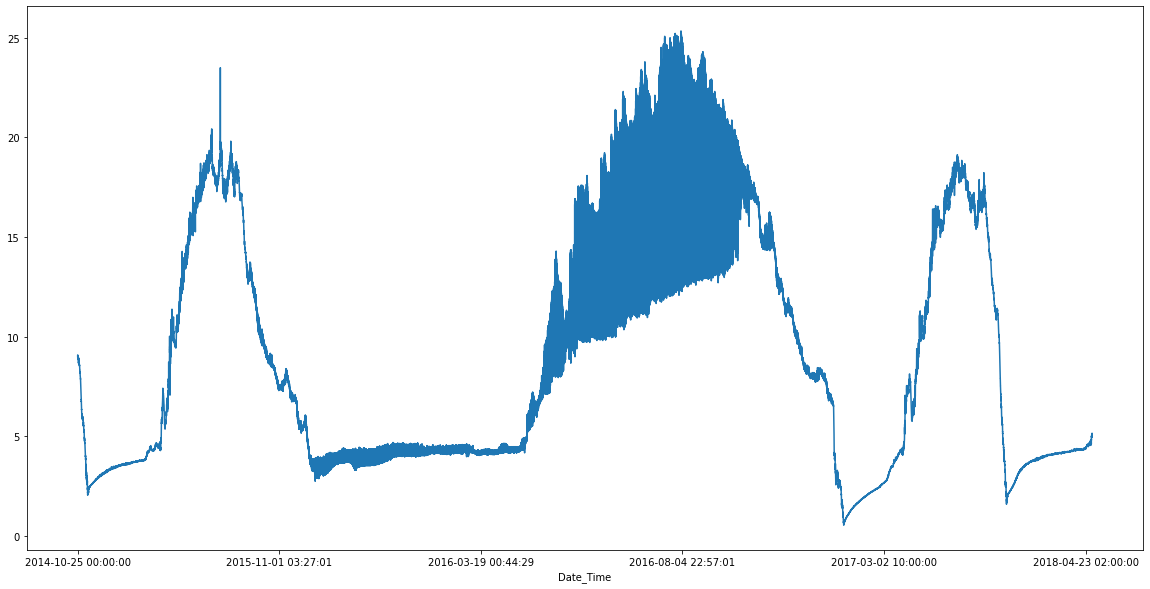

In [ ]:
season_temp.plot()

### Check the relations between the depth and the lake temperature

In [ ]:
depth_temp = df_train.groupby('Depth_m')['Water_Temp_C'].mean()

<AxesSubplot:xlabel='Depth_m'>

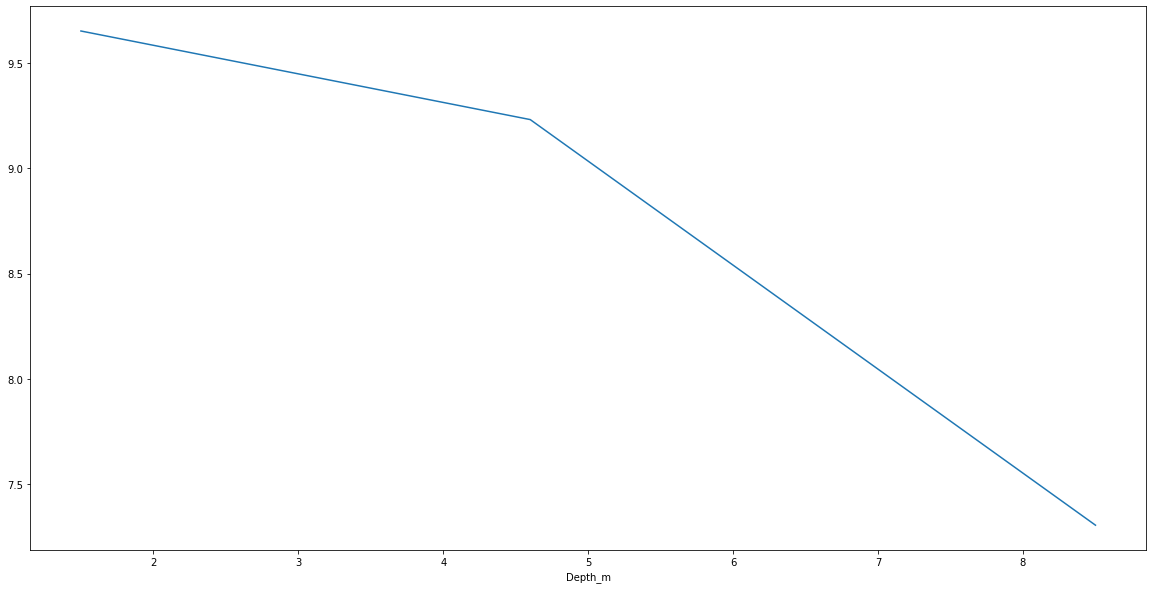

In [ ]:
depth_temp.plot()

### Temperature by year, month

Date_Time
2014    AxesSubplot(0.125,0.2;0.775x0.68)
2015    AxesSubplot(0.125,0.2;0.775x0.68)
2016    AxesSubplot(0.125,0.2;0.775x0.68)
2017    AxesSubplot(0.125,0.2;0.775x0.68)
2018    AxesSubplot(0.125,0.2;0.775x0.68)
Name: Water_Temp_C, dtype: object

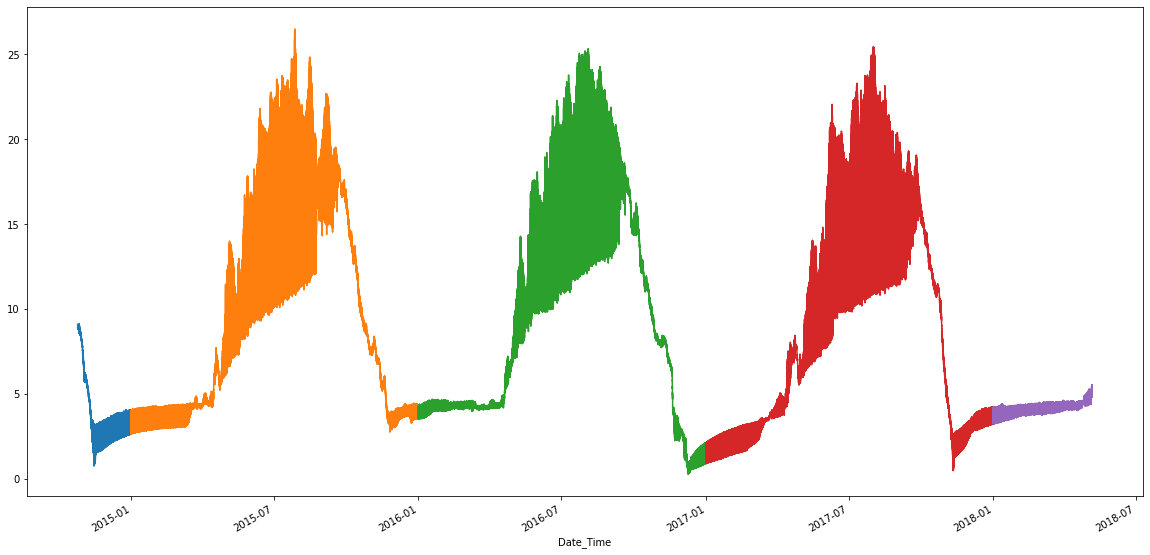

In [ ]:
df_datetime = df_train.set_index(['Date_Time'])
df_datetime.index = pd.to_datetime(df_datetime.index)
df_datetime.groupby(by=df_datetime.index.year)['Water_Temp_C'].plot()

Date_Time
1     AxesSubplot(0.125,0.2;0.775x0.68)
2     AxesSubplot(0.125,0.2;0.775x0.68)
3     AxesSubplot(0.125,0.2;0.775x0.68)
4     AxesSubplot(0.125,0.2;0.775x0.68)
5     AxesSubplot(0.125,0.2;0.775x0.68)
6     AxesSubplot(0.125,0.2;0.775x0.68)
7     AxesSubplot(0.125,0.2;0.775x0.68)
8     AxesSubplot(0.125,0.2;0.775x0.68)
9     AxesSubplot(0.125,0.2;0.775x0.68)
10    AxesSubplot(0.125,0.2;0.775x0.68)
11    AxesSubplot(0.125,0.2;0.775x0.68)
12    AxesSubplot(0.125,0.2;0.775x0.68)
Name: Water_Temp_C, dtype: object

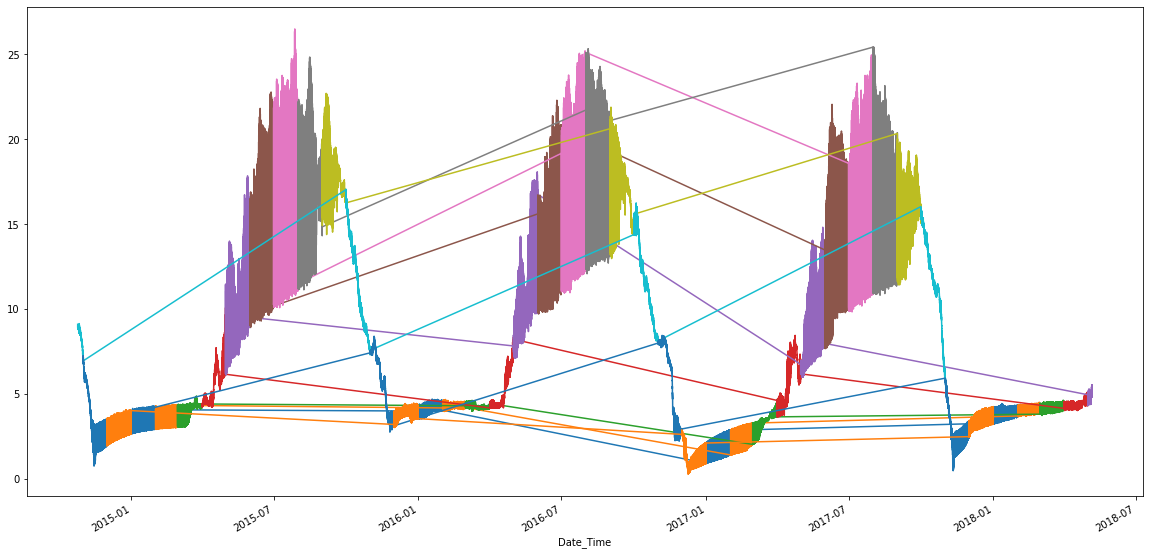

In [ ]:
df_datetime.groupby(by=df_datetime.index.month)['Water_Temp_C'].plot()

In [ ]:
df_train

,Date_Time,Water_Temp_C,Depth_m
0,2014-10-25 00:00:00,9.089,1.5
1,2014-10-25 00:00:00,8.916,4.6
2,2014-10-25 00:00:00,8.990,8.5
3,2014-10-25 00:30:00,9.089,1.5
4,2014-10-25 00:30:00,9.064,4.6
...,...,...,...
185631,2018-05-06 16:00:00,4.999,4.6
185632,2018-05-06 16:00:00,4.895,8.5
185633,2018-05-06 16:30:00,5.385,1.5
185634,2018-05-06 16:30:00,4.999,4.6


# 2. Preprocessing

In [ ]:
# change data format to datetime
df_train['Date_Time'] = pd.to_datetime(df_train['Date_Time'])
df_train['Date_Time'] = df_train['Date_Time'].dt.strftime('%-m/%-d/%Y %-H:%M')
df_train['Date_Time'] = pd.to_datetime(df_train['Date_Time'])

df_test['Date_Time'] = pd.to_datetime(df_test['Date_Time'])
df_test['Date_Time'] = df_test['Date_Time'].dt.strftime('%-m/%-d/%Y %-H:%M')
df_test['Date_Time'] = pd.to_datetime(df_test['Date_Time'])

In [ ]:
df_train.head()

,Date_Time,Water_Temp_C,Depth_m
0,2014-10-25 00:00:00,9.089,1.5
1,2014-10-25 00:00:00,8.916,4.6
2,2014-10-25 00:00:00,8.990,8.5
3,2014-10-25 00:30:00,9.089,1.5
4,2014-10-25 00:30:00,9.064,4.6


In [ ]:
df_train.shape

(185636, 3)

### Train-validation split

In [ ]:
# manually separate 80-20 of train data
train = df_train[:148499]
val = df_train[148499:]
#X_train = train[['Date_Time', 'Depth_m']]
#y_train = train['Water_Temp_C']
#X_val = val[['Date_Time', 'Depth_m']]
#y_val = val['Water_Temp_C']

## 3. Using Shaokotan and Trout lake temperature

In [ ]:
# import Shaokotan file
df_shao = pd.read_csv('Shaokotan.csv')
df_shao['Date_Time'] = pd.to_datetime(df_shao['Date_Time']).dt.floor('30Min')
df_shao

,Date_Time,Water_Temp_C,Depth_m
0,2013-05-09 00:00:00,10.736,0.5
1,2013-05-09 00:00:00,10.712,1.5
2,2013-05-09 00:00:00,9.336,3.0
3,2013-05-09 00:30:00,10.712,0.5
4,2013-05-09 00:30:00,10.687,1.5
...,...,...,...
300075,2019-07-16 15:30:00,25.331,1.5
300076,2019-07-16 15:30:00,23.905,3.0
300077,2019-07-16 16:00:00,26.304,0.5
300078,2019-07-16 16:00:00,25.331,1.5


In [ ]:
# import trout files
df_tr_train = pd.read_csv('Trout_training.csv')
df_tr_train['Date_Time'] = pd.to_datetime(df_tr_train['Date_Time']).dt.floor('30Min')
df_tr_train

,Date_Time,Water_Temp_C,Depth_m
0,2012-04-20 00:00:00,5.257,1.5
1,2012-04-20 00:00:00,5.257,2.5
2,2012-04-20 00:00:00,5.257,3.5
3,2012-04-20 00:00:00,5.205,4.5
4,2012-04-20 00:00:00,5.205,5.5
...,...,...,...
839210,2018-04-19 23:00:00,1.534,12.5
839211,2018-04-19 23:00:00,1.724,14.5
839212,2018-04-19 23:00:00,1.778,16.5
839213,2018-04-19 23:00:00,2.155,18.5


In [ ]:
# drop depth 10.5 in train since exact dataset of that depth doesn't exist in test dataset
df_tr_train.drop(df_tr_train[df_tr_train['Depth_m'] == 10.5 ].index, inplace = True)

In [ ]:
df_tr_train

,Date_Time,Water_Temp_C,Depth_m
0,2012-04-20 00:00:00,5.257,1.5
1,2012-04-20 00:00:00,5.257,2.5
2,2012-04-20 00:00:00,5.257,3.5
3,2012-04-20 00:00:00,5.205,4.5
4,2012-04-20 00:00:00,5.205,5.5
...,...,...,...
839210,2018-04-19 23:00:00,1.534,12.5
839211,2018-04-19 23:00:00,1.724,14.5
839212,2018-04-19 23:00:00,1.778,16.5
839213,2018-04-19 23:00:00,2.155,18.5


In [ ]:
# import file
df_tr_test = pd.read_csv('Trout_testing_features.csv')
df_tr_test['Date_Time'] = pd.to_datetime(df_tr_test['Date_Time']).dt.floor('30Min')
df_tr_test

,Date_Time,Water_Temp_C,Depth_m
0,2018-04-20 00:00:00,0.412,1.5
1,2018-04-20 00:00:00,0.852,2.5
2,2018-04-20 00:00:00,0.907,3.5
3,2018-04-20 00:00:00,0.962,4.5
4,2018-04-20 00:00:00,1.071,5.5
...,...,...,...
131395,2019-04-19 23:00:00,3.538,12.5
131396,2019-04-19 23:00:00,3.696,14.5
131397,2019-04-19 23:00:00,3.670,16.5
131398,2019-04-19 23:00:00,3.801,18.5


In [ ]:
df_trout = pd.concat([df_tr_train, df_tr_test], keys=['Date_Time', 'Depth_m'], ignore_index=True)
df_trout

,Date_Time,Water_Temp_C,Depth_m
0,2012-04-20 00:00:00,5.257,1.5
1,2012-04-20 00:00:00,5.257,2.5
2,2012-04-20 00:00:00,5.257,3.5
3,2012-04-20 00:00:00,5.205,4.5
4,2012-04-20 00:00:00,5.205,5.5
...,...,...,...
918102,2019-04-19 23:00:00,3.538,12.5
918103,2019-04-19 23:00:00,3.696,14.5
918104,2019-04-19 23:00:00,3.670,16.5
918105,2019-04-19 23:00:00,3.801,18.5


In [ ]:
# copy trout 2012 dataset to 2019 (until 2019-04-19 23:00:00) to match bear head test dataset format
df_trout_ext = pd.DataFrame({'Date_Time':df_trout[:6030].Date_Time,
                             'Water_Temp_C':df_trout[:6030].Water_Temp_C,
                             'Depth_m': df_trout[:6030].Depth_m})
df_trout_ext['Date_Time'] = df_trout_ext['Date_Time'].astype(str).str.replace('2012-','2019-')
df_trout = pd.concat([df_trout, df_trout_ext], keys=['Date_Time', 'Depth_m'], ignore_index=True)

In [ ]:
# make a function to make a pivot and merge for making full train-test set with two extra datas
def full_data(train_data, test_data, extra_data, extra_data2):
    train_data = train_data.pivot(index='Date_Time',columns='Depth_m')['Water_Temp_C']
    test_data = test_data.pivot(index='Date_Time',columns='Depth_m')['Water_Temp_C']
    extra_data = extra_data.pivot(index='Date_Time',columns='Depth_m')['Water_Temp_C']
    extra_data2 = extra_data2.pivot(index='Date_Time',columns='Depth_m')['Water_Temp_C']
    
    # merge with training data
    full_train = pd.merge(left=train_data, right=extra_data,  how='left', on = ['Date_Time'])
    full_train = pd.merge(left=full_train, right=extra_data2,  how='left', on = ['Date_Time'])

    # merge with testing data
    full_test = pd.merge(left=test_data, right=extra_data,  how='left', on = ['Date_Time'])
    full_test = pd.merge(left=full_test, right=extra_data2,  how='left', on = ['Date_Time'])
    
    # fillna with preceeding values
    full_train.fillna(method='ffill', inplace=True)
    full_test.fillna(method='ffill', inplace=True)
    
    return full_train, full_test

In [ ]:
# Merge with Shaokotan and Trout data to make a full train and validation data
full_train, full_val = full_data(train, val, df_shao, df_trout)

In [ ]:
full_train

Depth_m,1.5_x,4.6,8.5_x,0.5,1.5_y,3.0,1.5,2.5,3.5,4.5,...,6.5,7.5,8.5_y,9.5,11.5,12.5,14.5,16.5,18.5,20.5
Date_Time,,,,,,,,,,,,,,,,,,,,,
2014-10-25 00:00:00,9.089,8.916,8.990,11.856,11.856,11.929,8.990,8.866,9.040,8.941,...,8.941,9.040,9.040,9.015,9.064,8.891,6.331,5.411,5.257,5.076
2014-10-25 00:30:00,9.089,9.064,9.040,11.856,11.856,11.904,8.990,8.866,9.040,8.941,...,8.941,9.040,9.040,9.015,9.064,8.891,6.331,5.411,5.257,5.076
2014-10-25 01:00:00,9.089,9.089,9.064,11.832,11.832,11.904,8.965,8.866,9.040,8.941,...,8.941,9.040,9.040,9.040,9.064,8.891,6.331,5.385,5.231,5.076
2014-10-25 01:30:00,9.089,9.089,9.064,11.832,11.832,11.880,8.965,8.866,9.040,8.941,...,8.941,9.040,9.040,9.040,9.064,8.891,6.331,5.385,5.231,5.076
2014-10-25 02:00:00,9.089,8.990,9.040,11.783,11.807,11.880,8.965,8.866,9.015,8.941,...,8.941,9.040,9.040,9.015,9.064,8.891,6.535,5.334,5.205,5.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-21 16:30:00,21.032,20.579,11.443,22.034,22.034,21.270,20.388,20.174,19.912,19.841,...,19.008,13.353,10.320,8.941,7.995,7.519,6.687,6.179,6.153,6.102
2017-08-21 17:00:00,21.008,20.603,11.613,22.058,22.034,21.270,20.460,20.198,19.936,19.793,...,18.866,13.666,10.369,9.015,7.870,7.318,6.636,6.255,6.153,6.077
2017-08-21 17:30:00,21.032,20.603,11.516,22.058,22.034,21.270,20.460,20.198,19.936,19.793,...,18.866,13.666,10.369,9.015,7.870,7.318,6.636,6.255,6.153,6.077


In [ ]:
full_val

Depth_m,1.5_x,4.6,8.5_x,0.5,1.5_y,3.0,1.5,2.5,3.5,4.5,...,6.5,7.5,8.5_y,9.5,11.5,12.5,14.5,16.5,18.5,20.5
Date_Time,,,,,,,,,,,,,,,,,,,,,
2017-08-21 19:00:00,21.079,20.555,11.516,21.939,21.939,21.199,20.222,20.198,19.888,19.841,...,19.032,13.618,10.614,9.114,7.770,7.268,6.661,6.230,6.102,6.102
2017-08-21 19:30:00,21.079,20.555,11.540,21.939,21.939,21.199,20.222,20.198,19.888,19.841,...,19.032,13.618,10.614,9.114,7.770,7.268,6.661,6.230,6.102,6.102
2017-08-21 20:00:00,21.056,20.531,11.662,21.843,21.867,21.175,20.222,20.222,20.079,19.865,...,18.961,13.425,10.687,8.817,7.845,7.242,6.585,6.230,6.102,6.051
2017-08-21 20:30:00,21.079,20.531,11.710,21.843,21.867,21.175,20.222,20.222,20.079,19.865,...,18.961,13.425,10.687,8.817,7.845,7.242,6.585,6.230,6.102,6.051
2017-08-21 21:00:00,21.079,20.460,11.686,21.819,21.819,21.199,20.198,20.174,20.055,19.817,...,18.794,14.242,10.687,8.717,7.870,7.393,6.737,6.281,6.102,6.077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-06 14:30:00,5.539,4.999,4.895,12.751,12.727,12.461,2.797,2.877,2.770,2.770,...,2.610,2.797,2.690,2.744,2.744,2.690,2.797,2.744,2.797,2.744
2018-05-06 15:00:00,5.539,4.999,4.895,12.871,12.799,12.461,2.956,2.930,2.797,2.797,...,2.610,2.797,2.690,2.770,2.744,2.690,2.797,2.744,2.797,2.744
2018-05-06 15:30:00,5.539,4.999,4.869,12.920,12.823,12.509,2.956,2.930,2.797,2.797,...,2.610,2.797,2.690,2.770,2.744,2.690,2.797,2.744,2.797,2.744


In [ ]:
# Check the test set format
df_test.head()

,Date_Time,Depth_m
0,2018-05-06 17:00:00,1.5
1,2018-05-06 17:00:00,4.6
2,2018-05-06 17:00:00,8.5
3,2018-05-06 17:30:00,1.5
4,2018-05-06 17:30:00,4.6


## 4. Model Selection

### Import models

In [ ]:
# Linear regression
def linreg(X_train, X_test, y_train, y_test):
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    prediction = linreg.predict(X_test)
    linreg_mse = mean_squared_error(y_test, prediction)
    return linreg_mse


# Random Forest
def rf(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor(random_state=0)
    rf.fit(X_train,y_train)
    prediction = rf.predict(X_test)
    rf_mse = mean_squared_error(y_test, prediction)
    return rf_mse


# Ridge
def ridge(X_train, X_test, y_train, y_test):
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    prediction = ridge.predict(X_test)
    ridge_mse = mean_squared_error(y_test, prediction)
    return ridge_mse


# Lasso Regression
def lasso(X_train, X_test, y_train, y_test):
    lasso = Lasso()
    lasso.fit(X_train, y_train)
    prediction = lasso.predict(X_test)
    lasso_mse = mean_squared_error(y_test.values, prediction)
    return lasso_mse


# k Nearest Neighbor
def knn(X_train, X_test, y_train, y_test):
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(X_train, y_train)
    prediction = knn.predict(X_test)
    knn_mse = mean_squared_error(y_test, prediction)
    return knn_mse


# Support Vector Regression
def svr(X_train, X_test, y_train, y_test):
    svr = SVR()
    svr.fit(X_train, y_train)
    prediction = svr.predict(X_test)
    svc_mse = mean_squared_error(y_test, prediction)
    return svc_mse


# XGBoost
def xgbr(X_train, X_test, y_train, y_test):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=0, n_estimators = 50)
    xg_reg.fit(X_train,y_train)
    xg_preds = xg_reg.predict(X_test)
    xg_mse = mean_squared_error(y_test, xg_preds)
    return xg_mse


# Gradient Boosting
def gbr(X_train, X_test, y_train, y_test):
    gra_reg = GradientBoostingRegressor(random_state=0, n_estimators = 50)
    gra_reg.fit(X_train,y_train)
    gra_preds = gra_reg.predict(X_test)
    gra_mse = mean_squared_error(y_test, gra_preds)
    return gra_mse


# Ada Boost
def ada(X_train, X_test, y_train, y_test):
    ada_reg = AdaBoostRegressor(random_state=0, n_estimators = 50)
    ada_reg.fit(X_train,y_train)
    ada_preds = ada_reg.predict(X_test)
    ada_mse = mean_squared_error(y_test, ada_preds)
    return ada_mse


# Multi-layer Perceptron
def mlp(X_train, X_test, y_train, y_test):
    mlp_regr = MLPRegressor(random_state=1, max_iter=700, activation = 'tanh').fit(X_train, y_train)
    predictions=mlp_regr.predict(X_test)
    mlp_mse = mean_squared_error(y_test,predictions)
    return mlp_mse

In [ ]:
# Predict Depth_m: 1.5, 4.6, 8.5 one by one
def find_best_predictor(train_data, test_data):
    
    def select_model(train_X,test_X,train_y,test_y):
        models_mse={}
        for model in ['linreg', 'rf', 'ridge', 'lasso', 'knn', 'svr', 'xgboost', 'gb', 'ada', 'mlp']:
            if model == 'linreg':
                linreg_mse = linreg(train_X,test_X,train_y,test_y)
                models_mse['Linear Regression'] = linreg_mse
            elif model == 'rf':
                rf_mse = rf(train_X,test_X,train_y,test_y)
                models_mse['Random Forests Regression'] = rf_mse
            elif model == 'ridge':
                ridge_mse = ridge(train_X,test_X,train_y,test_y)
                models_mse['Ridge Regression'] = ridge_mse
            elif model == 'lasso':
                lasso_mse = lasso(train_X,test_X,train_y,test_y)
                models_mse['Lasso Regression'] = lasso_mse
            elif model == 'knn':
                knn_mse = knn(train_X,test_X,train_y,test_y)
                models_mse['KNN Regression'] = knn_mse
            elif model == 'svr':
                svc_mse = svr(train_X,test_X,train_y,test_y)
                models_mse['Support Vecotr Regression'] = svc_mse
            elif model == 'xgboost':
                xg_mse = xgbr(train_X,test_X,train_y,test_y)
                models_mse['XGBoost'] = xg_mse
            elif model == 'gb':
                gra_mse = gbr(train_X,test_X,train_y,test_y)
                models_mse['Gradient Boosting'] = gra_mse
            elif model == 'ada':
                ada_mse = ada(train_X,test_X,train_y,test_y)
                models_mse['Ada Boost Regression'] = ada_mse
            elif model == 'mlp':
                mlp_mse = mlp(train_X,test_X,train_y,test_y)
                models_mse['MLP Regression'] = mlp_mse
        return min(models_mse.items(), key=lambda x: x[1])

    # predict 1.5m first
    X_train = train_data[[ 0.5, '1.5_y', 3.0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 
                          '8.5_y', 9.5, 11.5, 12.5, 14.5, 16.5, 18.5, 20.5]]
    y_train = train_data[['1.5_x']]
    X_val = test_data[[ 0.5, '1.5_y', 3.0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 
                       '8.5_y', 9.5, 11.5, 12.5, 14.5, 16.5, 18.5, 20.5]]
    y_val = test_data[['1.5_x']]
    print('1.5m best predictor: ', select_model(X_train,X_val,y_train,y_val))
    
    # predict 4.6m
    X_train = train_data[[ 0.5, '1.5_y', 3.0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 
                          '8.5_y', 9.5, 11.5, 12.5, 14.5, 16.5, 18.5, 20.5]]
    y_train = train_data[[4.6]]
    X_val = test_data[[ 0.5, '1.5_y', 3.0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,
                       '8.5_y', 9.5, 11.5, 12.5, 14.5, 16.5, 18.5, 20.5]]
    y_val = test_data[[4.6]]
    print('4.6m best predictor: ', select_model(X_train,X_val,y_train,y_val))
    
    # predict 8.5m
    X_train = train_data[[ 0.5, '1.5_y', 3.0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 
                          '8.5_y', 9.5, 11.5, 12.5, 14.5, 16.5, 18.5, 20.5]]
    y_train = train_data[['8.5_x']]
    X_val = test_data[[ 0.5, '1.5_y', 3.0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,
                       '8.5_y', 9.5, 11.5, 12.5, 14.5, 16.5, 18.5, 20.5]]
    y_val = test_data[['8.5_x']]
    print('8.5m best predictor: ', select_model(X_train,X_val,y_train,y_val))
    
     

In [ ]:
find_best_predictor(full_train, full_val)

1.5m best predictor:  ('Gradient Boosting', 1.4471768251913928)
4.6m best predictor:  ('Gradient Boosting', 0.6536687917172612)
8.5m best predictor:  ('Gradient Boosting', 1.0654785429601292)


## 5. Make prediction on test set

In [ ]:
def full_data(train_data, test_data, extra_data, extra_data2):
    train_data = train_data.pivot(index='Date_Time',columns='Depth_m')['Water_Temp_C']
    test_data = test_data.pivot(index='Date_Time',columns='Depth_m')
    extra_data = extra_data.pivot(index='Date_Time',columns='Depth_m')['Water_Temp_C']
    extra_data2 = extra_data2.pivot(index='Date_Time',columns='Depth_m')['Water_Temp_C']
    
    # merge with training data
    full_train = pd.merge(left=train_data, right=extra_data,  how='left', on = ['Date_Time'])
    full_train = pd.merge(left=full_train, right=extra_data2,  how='left', on = ['Date_Time'])

    # merge with testing data
    full_test = pd.merge(left=test_data, right=extra_data,  how='left', on = ['Date_Time'])
    full_test = pd.merge(left=full_test, right=extra_data2,  how='left', on = ['Date_Time'])
    
    # fillna with preceeding values
    full_train.fillna(method='ffill', inplace=True)
    full_test.fillna(method='ffill', inplace=True)
    
    return full_train, full_test

In [ ]:
train, test = full_data(df_train, df_test, df_shao, df_trout)

In [ ]:
train

Depth_m,1.5_x,4.6,8.5_x,0.5,1.5_y,3.0,1.5,2.5,3.5,4.5,...,6.5,7.5,8.5_y,9.5,11.5,12.5,14.5,16.5,18.5,20.5
Date_Time,,,,,,,,,,,,,,,,,,,,,
2014-10-25 00:00:00,9.089,8.916,8.990,11.856,11.856,11.929,8.990,8.866,9.040,8.941,...,8.941,9.040,9.040,9.015,9.064,8.891,6.331,5.411,5.257,5.076
2014-10-25 00:30:00,9.089,9.064,9.040,11.856,11.856,11.904,8.990,8.866,9.040,8.941,...,8.941,9.040,9.040,9.015,9.064,8.891,6.331,5.411,5.257,5.076
2014-10-25 01:00:00,9.089,9.089,9.064,11.832,11.832,11.904,8.965,8.866,9.040,8.941,...,8.941,9.040,9.040,9.040,9.064,8.891,6.331,5.385,5.231,5.076
2014-10-25 01:30:00,9.089,9.089,9.064,11.832,11.832,11.880,8.965,8.866,9.040,8.941,...,8.941,9.040,9.040,9.040,9.064,8.891,6.331,5.385,5.231,5.076
2014-10-25 02:00:00,9.089,8.990,9.040,11.783,11.807,11.880,8.965,8.866,9.015,8.941,...,8.941,9.040,9.040,9.015,9.064,8.891,6.535,5.334,5.205,5.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-06 14:30:00,5.539,4.999,4.895,12.751,12.727,12.461,2.797,2.877,2.770,2.770,...,2.610,2.797,2.690,2.744,2.744,2.690,2.797,2.744,2.797,2.744
2018-05-06 15:00:00,5.539,4.999,4.895,12.871,12.799,12.461,2.956,2.930,2.797,2.797,...,2.610,2.797,2.690,2.770,2.744,2.690,2.797,2.744,2.797,2.744
2018-05-06 15:30:00,5.539,4.999,4.869,12.920,12.823,12.509,2.956,2.930,2.797,2.797,...,2.610,2.797,2.690,2.770,2.744,2.690,2.797,2.744,2.797,2.744


In [ ]:
test

,0.5,1.5_x,3.0,1.5_y,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,11.5,12.5,14.5,16.5,18.5,20.5
Date_Time,,,,,,,,,,,,,,,,,,
2018-05-06 17:00:00,13.185,13.016,12.413,2.850,2.956,2.823,2.797,2.823,2.637,2.823,2.717,2.770,2.744,2.690,2.797,2.744,2.797,2.770
2018-05-06 17:30:00,13.353,13.137,12.413,2.850,2.956,2.823,2.797,2.823,2.637,2.823,2.717,2.770,2.744,2.690,2.797,2.744,2.797,2.770
2018-05-06 18:00:00,13.522,13.281,12.389,2.956,2.983,2.850,2.823,2.823,2.637,2.823,2.744,2.797,2.744,2.690,2.797,2.744,2.770,2.770
2018-05-06 18:30:00,13.714,13.449,12.389,2.956,2.983,2.850,2.823,2.823,2.637,2.823,2.744,2.797,2.744,2.690,2.797,2.744,2.770,2.770
2018-05-06 19:00:00,13.906,13.473,12.413,3.142,3.063,2.903,2.877,2.877,2.690,2.877,2.770,2.797,2.797,2.717,2.823,2.744,2.797,2.717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-06 15:00:00,11.297,11.297,11.102,8.095,8.095,8.045,7.870,7.720,7.544,7.368,6.914,6.535,6.204,6.255,6.179,6.128,6.077,6.077
2019-05-06 15:30:00,11.273,11.297,11.127,8.095,8.095,8.045,7.870,7.720,7.544,7.368,6.914,6.535,6.204,6.255,6.179,6.128,6.077,6.077
2019-05-06 16:00:00,11.297,11.321,11.127,8.045,8.045,8.045,7.970,7.745,7.469,7.242,6.889,6.535,6.230,6.255,6.204,6.179,6.128,6.077


### prediction on 1.5m

In [ ]:
X_train = train[[ 0.5, '1.5_y', 3.0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,
                 '8.5_y', 9.5, 11.5, 12.5, 14.5, 16.5, 18.5, 20.5]]
y_train = train[['1.5_x']]
X_test = test

In [ ]:
gra_reg = GradientBoostingRegressor(random_state = 0, n_estimators = 100)
gra_reg.fit(X_train,y_train)
prediction_1 = gra_reg.predict(X_test)

In [ ]:
prediction_1

array([ 6.40018914,  6.40018914,  6.40018914, ..., 10.90979344,
       10.90979344, 10.90979344])

#### Model Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750]}

gra_reg = GradientBoostingRegressor(random_state=0)
search = RandomizedSearchCV(estimator=gra_reg,
                            param_distributions=params,
                            n_iter=25,
                            n_jobs=4,
                            verbose=1)

search.fit(X_train,y_train)

search.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/elizabethpark/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/elizabethpark/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/elizabethpark/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/elizabethpark/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with

{'subsample': 0.7999999999999999,
 'n_estimators': 100,
 'max_depth': 3,
 'learning_rate': 0.01}

In [ ]:
gra_reg = GradientBoostingRegressor(random_state=0, max_depth = 3, learning_rate = 0.01,
                                    subsample = 0.8, n_estimators = 100)
gra_reg.fit(X_train,y_train)
prediction_1 = gra_reg.predict(X_test)

In [ ]:
prediction_1

array([ 8.76021137,  8.76021137,  8.76021137, ..., 10.79792913,
       10.79792913, 10.79792913])

### 4.6m prediction

In [ ]:
X_train = train[[ 0.5, '1.5_y', 3.0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,
                 '8.5_y', 9.5, 11.5, 12.5, 14.5, 16.5, 18.5, 20.5]]
y_train = train[[4.6]]
X_test = test

In [ ]:
gra_reg = GradientBoostingRegressor(random_state = 0, n_estimators = 100)
gra_reg.fit(X_train,y_train)
prediction_2 = gra_reg.predict(X_test)

In [ ]:
prediction_2

array([ 5.9982806,  5.9982806,  5.951833 , ..., 10.8053593, 10.8053593,
       10.8053593])

#### Model Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750]}

gra_reg = GradientBoostingRegressor(random_state=0)
search = RandomizedSearchCV(estimator=gra_reg,
                            param_distributions=params,
                            n_iter=25,
                            n_jobs=4,
                            verbose=1)

search.fit(X_train,y_train)

search.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/elizabethpark/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/elizabethpark/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/elizabethpark/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/elizabethpark/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

{'subsample': 0.5, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01}

In [ ]:
gra_reg = GradientBoostingRegressor(random_state = 0,subsample = 0.5, n_estimators = 100, 
                                    max_depth = 15, learning_rate = 0.01)
gra_reg.fit(X_train,y_train)
prediction_2 = gra_reg.predict(X_test)

In [ ]:
prediction_2

array([ 6.72750571,  6.73121866,  6.72655935, ..., 10.94964917,
       10.94964917, 10.9501115 ])

### 8.5m prediction

In [ ]:
X_train = train[[ 0.5, '1.5_y', 3.0, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,
                 '8.5_y', 9.5, 11.5, 12.5, 14.5, 16.5, 18.5, 20.5]]
y_train = train[['8.5_x']]
X_test = test

In [ ]:
gra_reg = GradientBoostingRegressor(random_state = 0, n_estimators = 100)
gra_reg.fit(X_train,y_train)
prediction_3 = gra_reg.predict(X_test)

In [ ]:
prediction_3

array([5.09311437, 5.09311437, 5.09311437, ..., 7.84925258, 7.84925258,
       8.09733218])

#### Model Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750]
         }

gra_reg = GradientBoostingRegressor(random_state=0)
search = RandomizedSearchCV(estimator=gra_reg,
                            param_distributions=params,
                            n_iter=25,
                            n_jobs=4,
                            verbose=1)

search.fit(X_train,y_train)

search.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/elizabethpark/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/elizabethpark/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/elizabethpark/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/elizabethpark/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

{'subsample': 0.6, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01}

In [ ]:
gra_reg = GradientBoostingRegressor(random_state = 0, subsample = 0.6, n_estimators = 100, 
                                    max_depth = 15,learning_rate = 0.01)
gra_reg.fit(X_train,y_train)
prediction_3 = gra_reg.predict(X_test)

In [ ]:
prediction_3

array([5.93521888, 5.93629919, 5.95291634, ..., 7.96789606, 7.96789606,
       7.9634892 ])

## 6. Make submission file

In [ ]:
test['1.5_prediction'] = prediction_1
test['4.6_prediction'] = prediction_2
test['8.5_prediction'] = prediction_3

test.head()

,0.5,1.5_x,3.0,1.5_y,2.5,3.5,4.5,5.5,6.5,7.5,...,9.5,11.5,12.5,14.5,16.5,18.5,20.5,1.5_prediction,4.6_prediction,8.5_prediction
Date_Time,,,,,,,,,,,,,,,,,,,,,
2018-05-06 17:00:00,13.185,13.016,12.413,2.850,2.956,2.823,2.797,2.823,2.637,2.823,...,2.770,2.744,2.690,2.797,2.744,2.797,2.770,6.400189,5.998281,5.093114
2018-05-06 17:30:00,13.353,13.137,12.413,2.850,2.956,2.823,2.797,2.823,2.637,2.823,...,2.770,2.744,2.690,2.797,2.744,2.797,2.770,6.400189,5.998281,5.093114
2018-05-06 18:00:00,13.522,13.281,12.389,2.956,2.983,2.850,2.823,2.823,2.637,2.823,...,2.797,2.744,2.690,2.797,2.744,2.770,2.770,6.400189,5.951833,5.093114
2018-05-06 18:30:00,13.714,13.449,12.389,2.956,2.983,2.850,2.823,2.823,2.637,2.823,...,2.797,2.744,2.690,2.797,2.744,2.770,2.770,6.400189,5.951833,5.093114
2018-05-06 19:00:00,13.906,13.473,12.413,3.142,3.063,2.903,2.877,2.877,2.690,2.877,...,2.797,2.797,2.717,2.823,2.744,2.797,2.717,6.379559,6.161648,5.234398


In [ ]:
test = test[['1.5_prediction', '4.6_prediction', '8.5_prediction']]

In [ ]:
output = test.rename(columns={'1.5_prediction':1.5, '4.6_prediction':4.6, '8.5_prediction':8.5})

In [ ]:
output

,1.5,4.6,8.5
Date_Time,,,
2018-05-06 17:00:00,6.400189,5.998281,5.093114
2018-05-06 17:30:00,6.400189,5.998281,5.093114
2018-05-06 18:00:00,6.400189,5.951833,5.093114
2018-05-06 18:30:00,6.400189,5.951833,5.093114
2018-05-06 19:00:00,6.379559,6.161648,5.234398
...,...,...,...
2019-05-06 15:00:00,10.909793,10.805359,7.849253
2019-05-06 15:30:00,10.909793,10.805359,7.849253
2019-05-06 16:00:00,10.909793,10.805359,7.849253


In [ ]:
submission = output.stack()

In [ ]:
submission = submission.rename_axis(['Date_Time', 'Depth_m'])

In [ ]:
submission

Date_Time            Depth_m
2018-05-06 17:00:00  1.5         6.400189
                     4.6         5.998281
                     8.5         5.093114
2018-05-06 17:30:00  1.5         6.400189
                     4.6         5.998281
                                  ...    
2019-05-06 16:30:00  4.6        10.805359
                     8.5         7.849253
2019-05-06 17:00:00  1.5        10.909793
                     4.6        10.805359
                     8.5         8.097332
Length: 52563, dtype: float64

In [ ]:
submission = pd.DataFrame(submission)
submission

0
Date_Time           Depth_m           
2018-05-06 17:00:00 1.5       6.400189
                    4.6       5.998281
                    8.5       5.093114
2018-05-06 17:30:00 1.5       6.400189
                    4.6       5.998281
...                                ...
2019-05-06 16:30:00 4.6      10.805359
                    8.5       7.849253
2019-05-06 17:00:00 1.5      10.909793
                    4.6      10.805359
                    8.5       8.097332

[52563 rows x 1 columns]

In [ ]:
prediction = submission.reset_index()
prediction = prediction.drop_duplicates()

In [ ]:
prediction

,Date_Time,Depth_m,0
0,2018-05-06 17:00:00,1.5,6.400189
1,2018-05-06 17:00:00,4.6,5.998281
2,2018-05-06 17:00:00,8.5,5.093114
3,2018-05-06 17:30:00,1.5,6.400189
4,2018-05-06 17:30:00,4.6,5.998281
...,...,...,...
52558,2019-05-06 16:30:00,4.6,10.805359
52559,2019-05-06 16:30:00,8.5,7.849253
52560,2019-05-06 17:00:00,1.5,10.909793
52561,2019-05-06 17:00:00,4.6,10.805359


In [ ]:
prediction15 = prediction.loc[prediction['Depth_m'] == 1.5]

<AxesSubplot:>

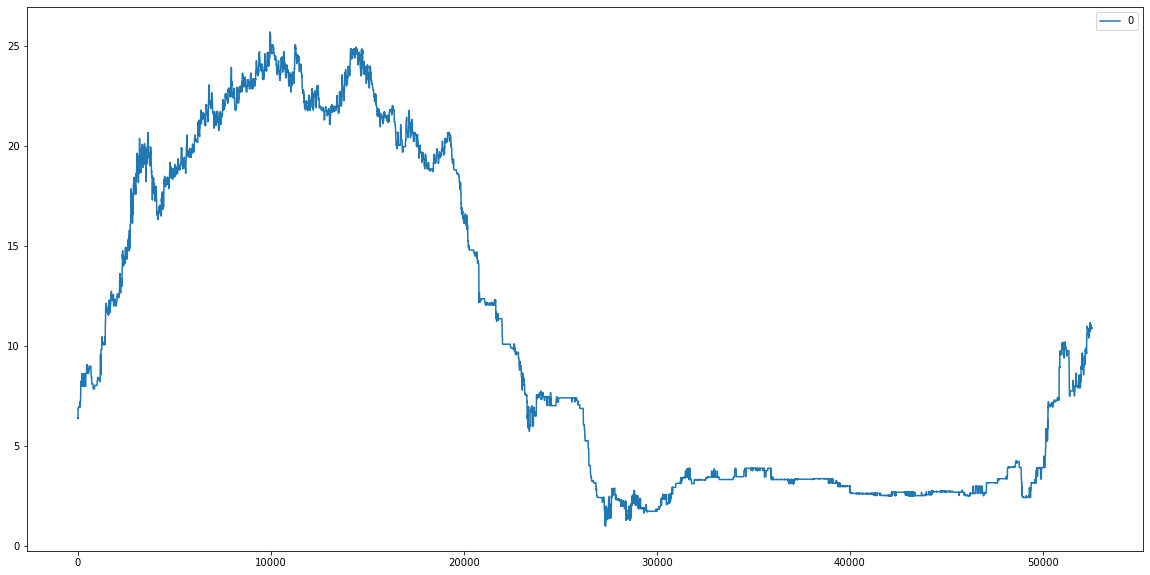

In [ ]:
prediction15.plot(y=0)

In [ ]:
prediction46 = prediction.loc[prediction['Depth_m'] == 4.6]

<AxesSubplot:>

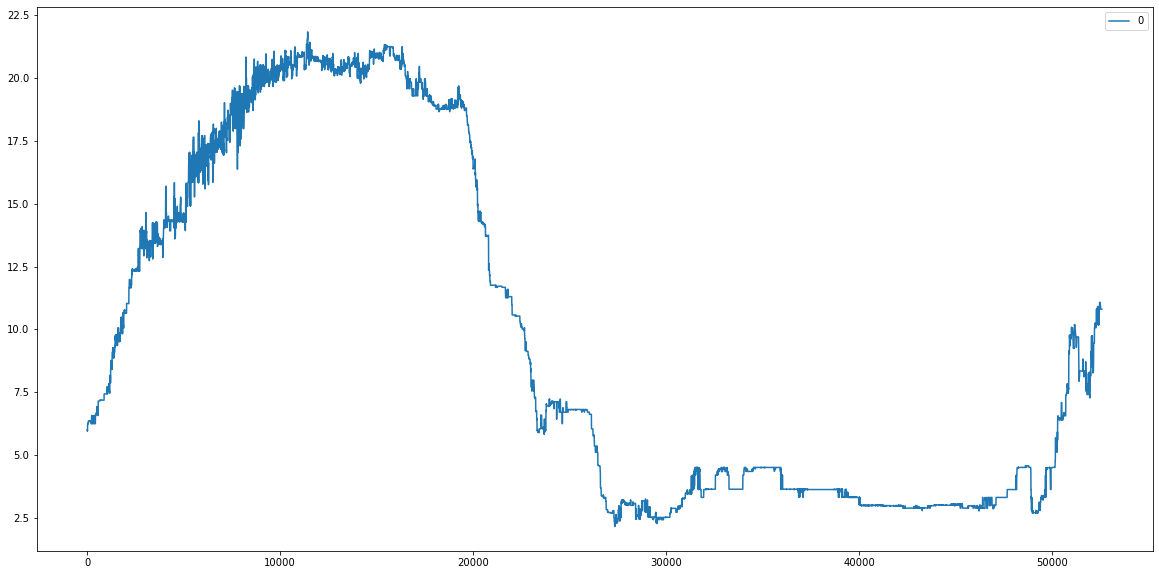

In [ ]:
prediction46.plot(y=0)

In [ ]:
prediction85 = prediction.loc[prediction['Depth_m'] == 8.5]

<AxesSubplot:>

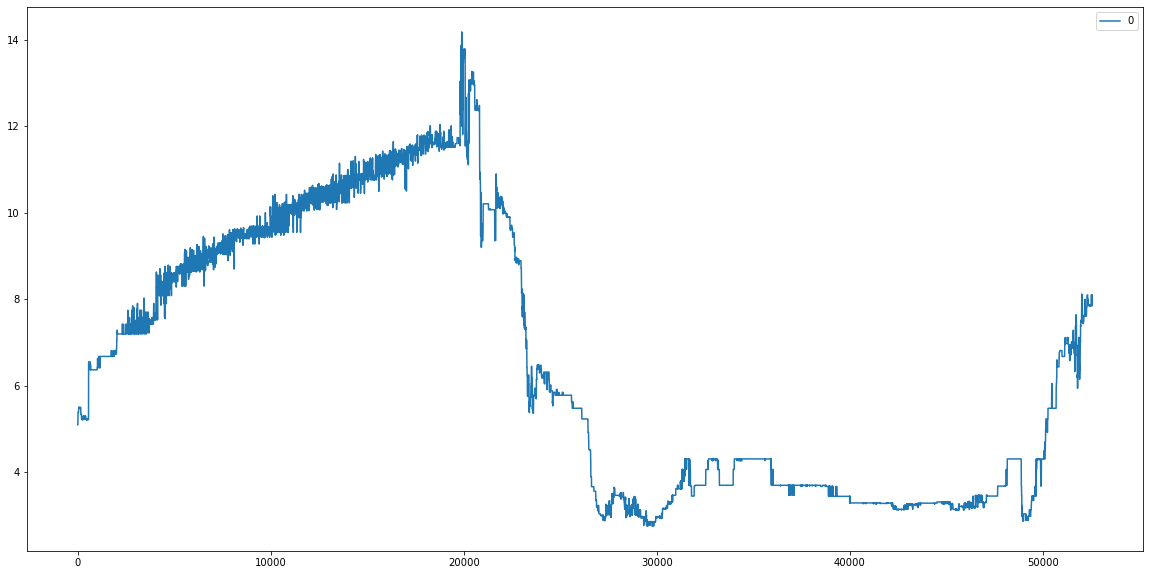

In [ ]:
prediction85.plot(y=0)

In [ ]:
prediction_output = pd.merge(left=df_test, right=prediction,  how='left', on = ['Date_Time', 'Depth_m'])
prediction_output = prediction_output.drop_duplicates(subset=['Date_Time', 'Depth_m'])
prediction_output['Date_Time_Depth_m'] = prediction_output['Date_Time'].astype(str) + '-' + prediction_output['Depth_m'].astype(str)
final_prediction = prediction_output[['Date_Time_Depth_m', 0]].rename(columns={'Date_Time_Depth_m':'Date_Time_with_Depth', 0:'Water_Temp_C'}).set_index('Date_Time_with_Depth')

final_prediction.to_csv('./Bear_Head_prediction.csv', index=True)

In [ ]:
final_prediction

,Water_Temp_C
Date_Time_with_Depth,
2018-05-06 17:00:00-1.5,6.400189
2018-05-06 17:00:00-4.6,5.998281
2018-05-06 17:00:00-8.5,5.093114
2018-05-06 17:30:00-1.5,6.400189
2018-05-06 17:30:00-4.6,5.998281
...,...
2019-05-06 16:30:00-4.6,10.805359
2019-05-06 16:30:00-8.5,7.849253
2019-05-06 17:00:00-1.5,10.909793


<AxesSubplot:xlabel='Date_Time_with_Depth'>

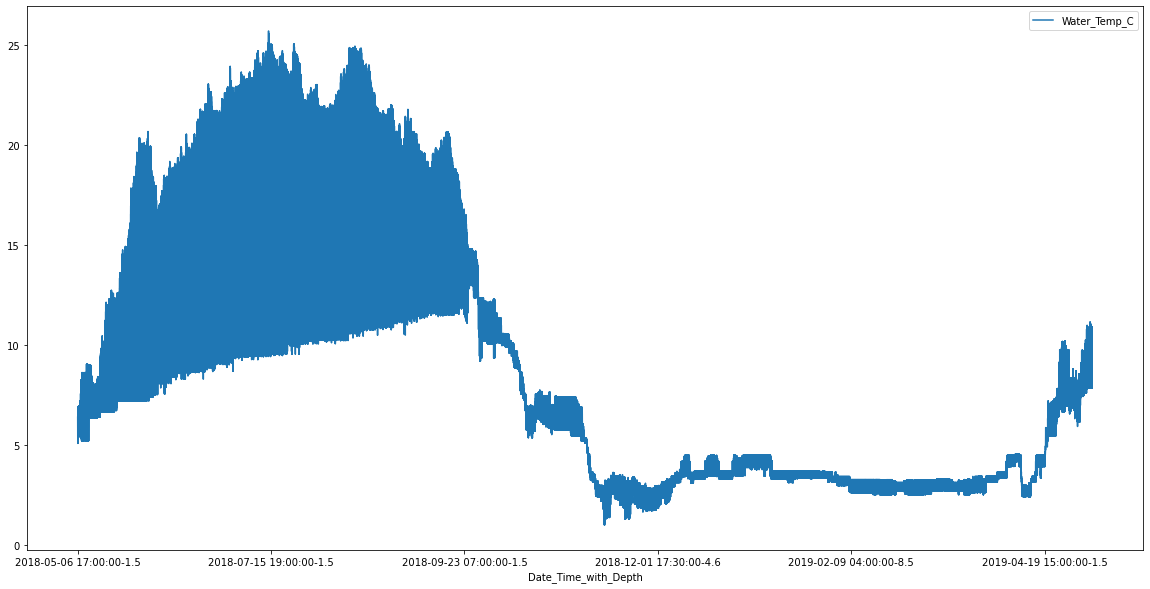

In [ ]:
final_prediction.plot(y='Water_Temp_C')